In [1]:
import os
import hashlib
from pathlib import Path
import pandas as pd
import numpy as np
import fastparquet as fp
import scipy.stats
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB3, MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (GlobalAveragePooling2D, Dense, Dropout,
                                     concatenate, Input, BatchNormalization,
                                     Activation)
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import joblib
from tqdm import tqdm
from IPython.display import display, HTML, clear_output
from ipywidgets import FloatProgress

In [2]:
PROJECT_ROOT = Path('tobacco_grading')

PATHS = {
    'raw': PROJECT_ROOT / 'data/raw',
    'processed': PROJECT_ROOT / 'data/processed/images',
    'metadata': PROJECT_ROOT / 'data/processed/metadata.csv',
    'features': PROJECT_ROOT / 'data/processed/full_features.parquet',
    'processors': PROJECT_ROOT / 'model/processors.pkl',
    'model': PROJECT_ROOT / 'model'
}

for path in PATHS.values():
    if isinstance(path, Path) and path.suffix not in {'.csv', '.parquet', '.pkl'}:
        path.mkdir(parents=True, exist_ok=True)

In [3]:
def show_status(message, status_type='info'):
    status_config = {
        'info': {
            'color': '#004085',
            'bg_color': 'rgba(0, 64, 133, 0.1)',
            'icon': 'ℹ️'
        },
        'success': {
            'color': '#155724',
            'bg_color': 'rgba(40, 167, 69, 0.1)',
            'icon': '✅'
        },
        'warning': {
            'color': '#856404',
            'bg_color': 'rgba(255, 193, 7, 0.1)',
            'icon': '⚠️'
        },
        'error': {
            'color': '#721c24',
            'bg_color': 'rgba(220, 53, 69, 0.1)',
            'icon': '❌'
        }
    }

    config = status_config.get(status_type.lower(), status_config['info'])
    safe_message = HTML(message).data.replace('\n', '<br>')

    html = f"""
    <div style="
        border: 1px solid {config['color']};
        background-color: {config['bg_color']};
        color: {config['color']};
        padding: 12px 18px;
        margin: 10px 0;
        border-radius: 5px;
        font-family: sans-serif;
        font-size: 14px;
        animation: fadeIn 0.5s ease-out;
        line-height: 1.6;
    ">
        <span style="font-weight: bold; margin-right: 8px;">{config['icon']} {status_type.upper()}:</span>
        {safe_message}
    </div>
    <style>
        @keyframes fadeIn {{
            from {{ opacity: 0; transform: translateY(-10px); }}
            to {{ opacity: 1; transform: translateY(0); }}
        }}
    </style>
    """
    display(HTML(html))

In [4]:
def enhanced_process_images():
    clear_output(wait=True)
    show_status("Starting enhanced image processing...", 'info')
    try:
        raw_path = Path(PATHS['raw'])
        if not raw_path.exists():
            show_status(f"Raw data directory not found: {raw_path}", 'error')
            return

        supported_formats = ('.png', '.jpg', '.jpeg', '.webp')
        image_paths = [
            p for p in raw_path.rglob('*')
            if p.suffix.lower() in supported_formats and p.is_file()
        ]

        if not image_paths:
            show_status('No valid images found in raw directory.', 'error')
            return
        show_status(f"Found {len(image_paths)} images to process.", 'info')

        progress = FloatProgress(min=0, max=len(image_paths)+3, description='Initializing:', bar_style='info')
        display(progress)

        processed_paths = []
        original_sizes = []
        failure_count = 0

        progress.description = 'Processing images...'
        processing_params = {
            'target_size': (512, 512),
            'bilateral_filter': {'d': 9, 'sigma_color': 75, 'sigma_space': 75},
            'clahe': {'clip_limit': 3.0, 'tile_grid_size': (8, 8)},
            'quality': 95,
            'denoise_strength': 10,
        }

        for path in image_paths:
            try:
                original_sizes.append(path.stat().st_size)

                img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
                if img is None or img.size == 0:
                    raise ValueError("Invalid or corrupted image file")

                if len(img.shape) == 2:
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                elif img.shape[2] == 4:
                    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
                elif img.shape[2] == 3:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                else:
                    raise ValueError(f"Unsupported number of channels: {img.shape[2]}")

                img = cv2.fastNlMeansDenoisingColored(
                    img, None,
                    processing_params['denoise_strength'], processing_params['denoise_strength'],
                    7, 21
                )

                img = cv2.resize(
                    img, processing_params['target_size'], interpolation=cv2.INTER_LANCZOS4
                )

                img = cv2.bilateralFilter(
                    img,
                    processing_params['bilateral_filter']['d'],
                    processing_params['bilateral_filter']['sigma_color'],
                    processing_params['bilateral_filter']['sigma_space']
                )

                lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
                l, a, b = cv2.split(lab)
                clahe = cv2.createCLAHE(
                    clipLimit=processing_params['clahe']['clip_limit'],
                    tileGridSize=processing_params['clahe']['tile_grid_size']
                )
                l = clahe.apply(l)
                lab = cv2.merge((l, a, b))
                img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

                kernel = np.array([[-1, -1, -1],
                                   [-1,  9, -1],
                                   [-1, -1, -1]])
                img = cv2.filter2D(img, -1, kernel)

                rel_path = path.relative_to(raw_path)
                dest_path = Path(PATHS['processed']) / rel_path
                dest_path.parent.mkdir(parents=True, exist_ok=True)

                cv2.imwrite(
                    str(dest_path),
                    cv2.cvtColor(img, cv2.COLOR_RGB2BGR),
                    [int(cv2.IMWRITE_JPEG_QUALITY), processing_params['quality']]
                )

                processed_paths.append(str(dest_path))

            except Exception as e:
                failure_count += 1
                show_status(f"Skipped {path.name}: {str(e)}", 'warning')
                processed_paths.append(None)

            progress.value += 1

        progress.description = 'Creating metadata...'
        metadata = pd.DataFrame({
            'original_path': [str(p) for p in image_paths],
            'processed_path': processed_paths,
            'label': [p.parent.name for p in image_paths],
            'original_size': original_sizes
        })
        metadata['processing_success'] = metadata['processed_path'].notnull()

        valid_metadata = metadata.dropna(subset=['processed_path']).reset_index(drop=True)
        if valid_metadata.empty:
            show_status('No images were processed successfully. Cannot create metadata.', 'error')
            return

        progress.description = 'Calculating statistics...'
        def get_image_stats(img_path_str):
            try:
                img_path = Path(img_path_str)
                img = cv2.imread(img_path_str)
                if img is None: return None
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                mean_rgb = np.mean(img, axis=(0, 1))
                std_rgb = np.std(img, axis=(0, 1))

                hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
                mean_hsv = np.mean(hsv, axis=(0, 1))

                gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
                hist = hist / hist.sum()
                entropy = -np.sum(hist * np.log2(hist + 1e-7))

                return {
                    'mean_r': mean_rgb[0], 'mean_g': mean_rgb[1], 'mean_b': mean_rgb[2],
                    'std_r': std_rgb[0], 'std_g': std_rgb[1], 'std_b': std_rgb[2],
                    'mean_hue': mean_hsv[0], 'mean_saturation': mean_hsv[1], 'mean_value': mean_hsv[2],
                    'entropy': entropy,
                    'processed_size': img_path.stat().st_size
                }
            except Exception as e:
                return None

        stats_list = [get_image_stats(p) for p in tqdm(valid_metadata['processed_path'], desc="Calculating image statistics")]
        stats_df = pd.DataFrame([s if s is not None else {} for s in stats_list])

        valid_metadata = pd.concat([valid_metadata, stats_df], axis=1)
        progress.value += 1

        progress.description = 'Generating checksums...'
        def calculate_checksum(p_str):
            if pd.isna(p_str): return ''
            try:
                return hashlib.md5(Path(p_str).read_bytes()).hexdigest()
            except FileNotFoundError:
                return ''
            except Exception:
                return ''

        valid_metadata['checksum'] = [calculate_checksum(p) for p in valid_metadata['processed_path']]
        progress.value += 1

        metadata_path = PATHS['metadata']
        valid_metadata.to_csv(metadata_path, index=False)
        show_status(f"Metadata saved to {metadata_path}", 'success')

        clear_output(wait=True)
        success_count = len(valid_metadata)
        total_count = len(image_paths)
        success_rate = success_count / total_count * 100 if total_count > 0 else 0
        total_orig_size = sum(metadata['original_size'])
        total_proc_size = valid_metadata['processed_size'].sum()
        compression_ratio = total_proc_size / total_orig_size if total_orig_size > 0 else 0

        summary = f"""
        Processed {success_count}/{total_count} images successfully ({success_rate:.1f}%)
        - Failures: {failure_count}
        - Input size (Original): {total_orig_size / 1e6:.2f} MB
        - Output size (Processed): {total_proc_size / 1e6:.2f} MB
        - Effective Compression Ratio: {compression_ratio:.2f} (Processed/Original)
        - Average Entropy: {valid_metadata['entropy'].mean():.2f} (Image Complexity)
        - Color analysis completed with {valid_metadata.filter(like='mean_').shape[1]} metrics
        - Checksums generated for processed files.
        """
        show_status(summary, 'success')

        if success_count > 0:
            display(HTML("<h2>Enhanced Processing Report</h2>"))

            label_counts = valid_metadata['label'].value_counts()
            num_labels_to_show = min(3, len(label_counts))
            if num_labels_to_show > 0:
                most_common_labels = label_counts.nlargest(num_labels_to_show).index
                samples = pd.concat([
                    valid_metadata[valid_metadata['label'] == label].sample(1, random_state=42)
                    for label in most_common_labels if not valid_metadata[valid_metadata['label'] == label].empty
                ])

                if not samples.empty:
                    fig, axes = plt.subplots(2, len(samples), figsize=(6 * len(samples), 10))
                    if len(samples) == 1: axes = np.array([[axes[0]],[axes[1]]])

                    for idx, (_, row) in enumerate(samples.iterrows()):
                        try:
                            orig_img = Image.open(row['original_path'])
                            axes[0, idx].imshow(orig_img)
                            axes[0, idx].set_title(f"Original: {row['label']}\n{Path(row['original_path']).name}", fontsize=10)
                        except FileNotFoundError:
                            axes[0, idx].set_title(f"Original: {row['label']}\n(File not found)", fontsize=10)
                        except Exception as img_e:
                            axes[0, idx].set_title(f"Original: {row['label']}\n(Error loading)", fontsize=10)

                        try:
                            proc_img = Image.open(row['processed_path'])
                            axes[1, idx].imshow(proc_img)
                            axes[1, idx].set_title(
                                f"Processed: {row['processed_size']/1e3:.1f} KB | Entropy: {row['entropy']:.2f}\n{Path(row['processed_path']).name}",
                                fontsize=10
                            )
                        except FileNotFoundError:
                            axes[1, idx].set_title(f"Processed:\n(File not found)", fontsize=10)
                        except Exception as img_e:
                            axes[1, idx].set_title(f"Processed:\n(Error loading)", fontsize=10)

                        for ax_row in range(2):
                            axes[ax_row, idx].axis('off')

                    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                    fig.suptitle("Image Quality Comparison (Sample)", fontsize=16)
                    plt.show()

            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            fig.suptitle("Data Distribution Analysis", fontsize=16)

            axes[0, 0].hist(valid_metadata['original_size']/1e3, alpha=0.6, label='Original Size (Success only)', bins=30, color='blue')
            axes[0, 0].hist(valid_metadata['processed_size']/1e3, alpha=0.6, label='Processed Size', bins=30, color='green')
            axes[0, 0].set_xlabel('File Size (KB)')
            axes[0, 0].set_ylabel('Count')
            axes[0, 0].set_title('File Size Distribution')
            axes[0, 0].legend()
            axes[0, 0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

            valid_metadata['label'].value_counts().plot(kind='bar', ax=axes[0, 1], color='skyblue')
            axes[0, 1].set_title('Class Distribution (Processed Images)')
            axes[0, 1].set_xlabel('Label')
            axes[0, 1].set_ylabel('Count')
            plt.setp(axes[0, 1].get_xticklabels(), rotation=45, ha="right")

            top_classes = valid_metadata['label'].value_counts().nlargest(5).index
            colors = plt.cm.viridis(np.linspace(0, 1, len(top_classes)))
            for i, label in enumerate(top_classes):
                class_data = valid_metadata[valid_metadata['label'] == label]
                axes[1, 0].scatter(
                    class_data['mean_r'], class_data['mean_g'],
                    label=label, alpha=0.7, color=colors[i]
                )
            axes[1, 0].set_title('Mean Red vs Green by Top 5 Classes')
            axes[1, 0].set_xlabel('Mean Red Value')
            axes[1, 0].set_ylabel('Mean Green Value')
            axes[1, 0].legend()

            entropy_by_class = [valid_metadata[valid_metadata['label'] == label]['entropy'].dropna() for label in top_classes]
            axes[1, 1].boxplot(entropy_by_class, labels=top_classes)
            axes[1, 1].set_title('Image Entropy by Top 5 Classes')
            axes[1, 1].set_ylabel('Entropy (Complexity)')
            plt.setp(axes[1, 1].get_xticklabels(), rotation=45, ha="right")

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

    except Exception as e:
        show_status(f'Critical processing failure: {str(e)}', 'error')

In [5]:
class EnhancedFeatureExtractor:
    def __init__(self, use_ensemble=True, pca_components=256, target_size=(224, 224)):
        show_status(f"Initializing Feature Extractor (Ensemble: {use_ensemble}, PCA: {pca_components})", 'info')
        self.target_size = target_size
        self.input_shape = target_size + (3,)

        self.models = {}
        self.preprocess_funcs = {}
        self.layer_names = {}

        try:
            base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=self.input_shape)
            self.models['resnet'] = base_resnet
            self.preprocess_funcs['resnet'] = resnet_preprocess
            self.layer_names['resnet'] = [
                'conv1_relu',
                'conv2_block3_out',
                'conv3_block4_out',
                'conv4_block6_out',
                'conv5_block3_out'
            ]
            show_status("ResNet50 loaded.", 'success')

            self.use_ensemble = use_ensemble
            if use_ensemble:
                base_efficientnet = EfficientNetB3(weights='imagenet', include_top=False, input_shape=self.input_shape)
                self.models['efficientnet'] = base_efficientnet
                self.preprocess_funcs['efficientnet'] = efficientnet_preprocess
                self.layer_names['efficientnet'] = [
                    'block2a_expand_activation',
                    'block3a_expand_activation',
                    'block4a_expand_activation',
                    'block6a_expand_activation',
                    'top_activation'
                ]
                show_status("EfficientNetB3 loaded.", 'success')

                base_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=self.input_shape)
                self.models['mobilenet'] = base_mobilenet
                self.preprocess_funcs['mobilenet'] = mobilenet_preprocess
                self.layer_names['mobilenet'] = [
                    'block_1_expand_relu',
                    'block_3_expand_relu',
                    'block_6_expand_relu',
                    'block_13_expand_relu',
                    'out_relu'
                ]
                show_status("MobileNetV2 loaded.", 'success')

        except Exception as e:
            show_status(f"Error loading base CNN models: {e}", 'error')
            raise

        self.feature_models = self._create_feature_models()
        self.scaler = MinMaxScaler()
        self.is_scaler_fitted = False
        self.use_pca = pca_components is not None and pca_components > 0
        if self.use_pca:
            self.pca = PCA(n_components=pca_components)
            self.is_pca_fitted = False
            show_status(f"PCA enabled with {pca_components} components.", 'info')
        else:
            self.pca = None
            self.is_pca_fitted = False
            show_status("PCA is disabled.", 'info')

    def _create_feature_models(self):
        feature_models = {}
        for name, base_model in self.models.items():
            if name in self.layer_names:
                try:
                    outputs = [base_model.get_layer(layer_name).output for layer_name in self.layer_names[name]]
                    feature_models[name] = Model(inputs=base_model.input, outputs=outputs, name=f"{name}_feature_extractor")
                    show_status(f"Created feature extractor for {name} with {len(outputs)} output layers.", 'info')
                except Exception as e:
                    show_status(f"Error creating feature model for {name}: {e}", 'warning')
            else:
                output = GlobalAveragePooling2D()(base_model.output)
                feature_models[name] = Model(inputs=base_model.input, outputs=output, name=f"{name}_gap_feature_extractor")
                show_status(f"Using GlobalAveragePooling for {name} (layers not specified or found).", 'warning')

        return feature_models

    def _process_layer_output(self, layer_outputs):
        processed_features = []
        if not isinstance(layer_outputs, list):
            layer_outputs = [layer_outputs]

        for layer_feat in layer_outputs:
            if len(layer_feat.shape) == 4:
                axis_to_reduce = (1, 2)

                gap = np.mean(layer_feat, axis=axis_to_reduce)
                gmp = np.max(layer_feat, axis=axis_to_reduce)
                std = np.std(layer_feat, axis=axis_to_reduce)
                act_range = np.max(layer_feat, axis=axis_to_reduce) - np.min(layer_feat, axis=axis_to_reduce)
                median = np.median(layer_feat, axis=axis_to_reduce)

                combined = np.concatenate([gap, gmp, std, act_range, median], axis=1)
                processed_features.append(combined)
            elif len(layer_feat.shape) == 2:
                processed_features.append(layer_feat)

        if not processed_features:
            return np.array([[]])
        return np.concatenate(processed_features, axis=1)

    def _load_and_preprocess_image(self, path, model_name):
        try:
            img = cv2.imread(str(path))
            if img is None:
                raise ValueError("Empty image file")

            if len(img.shape) == 2: img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            if img.shape[2] == 4: img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            l = clahe.apply(l)
            lab = cv2.merge((l, a, b))
            img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

            img = cv2.bilateralFilter(img, d=5, sigmaColor=50, sigmaSpace=50)
            img = cv2.resize(img, self.target_size, interpolation=cv2.INTER_LANCZOS4)

            preprocess_func = self.preprocess_funcs.get(model_name)
            if preprocess_func:
                return preprocess_func(np.expand_dims(img.astype(np.float32), axis=0))
            else:
                return np.expand_dims(img.astype(np.float32) / 255.0, axis=0)

        except Exception as e:
            show_status(f"Error processing image {Path(path).name}: {str(e)}", 'warning')
            return None

    def process_batch(self, image_paths, fit_processors=False):
        batch_features_dict = {name: [] for name in self.models.keys()}
        valid_paths_in_batch = []
        processed_images_dict = {name: [] for name in self.models.keys()}

        for path in image_paths:
            processed_successfully_for_all = True
            temp_processed_images = {}
            for model_name in self.models.keys():
                processed_img = self._load_and_preprocess_image(path, model_name)
                if processed_img is None:
                    processed_successfully_for_all = False
                    break
                temp_processed_images[model_name] = processed_img

            if processed_successfully_for_all:
                valid_paths_in_batch.append(path)
                for model_name, img_data in temp_processed_images.items():
                    processed_images_dict[model_name].append(img_data[0])

        if not valid_paths_in_batch:
            return np.array([]), []

        batch_combined_features = []
        for model_name, feature_model in self.feature_models.items():
            if model_name not in self.models: continue
            if not self.use_ensemble and model_name != 'resnet': continue
            if not processed_images_dict[model_name]: continue

            model_batch_array = np.array(processed_images_dict[model_name])

            if model_batch_array.size == 0: continue

            layer_outputs = feature_model.predict(model_batch_array, verbose=0)
            model_features = self._process_layer_output(layer_outputs)
            batch_features_dict[model_name] = model_features

        if self.use_ensemble:
            min_samples = min(f.shape[0] for f in batch_features_dict.values() if f.shape[0] > 0)
            valid_features_list = []
            for name, features in batch_features_dict.items():
                if features.shape[0] >= min_samples:
                    valid_features_list.append(features[:min_samples, :])

            if valid_features_list:
                batch_combined_features = np.concatenate(valid_features_list, axis=1)
            else:
                batch_combined_features = np.array([])
        else:
            batch_combined_features = batch_features_dict.get('resnet', np.array([]))

        if batch_combined_features.size == 0:
            return np.array([]), []

        if fit_processors:
            if batch_combined_features.shape[0] > 1:
                self.scaler.fit(batch_combined_features)
                self.is_scaler_fitted = True
                show_status("Scaler fitted.", 'info')
            else:
                show_status("Skipping scaler fitting (only 1 sample in batch).", 'warning')
                if self.use_pca:
                    show_status("Skipping PCA as scaler was not fitted.", 'warning')
                return batch_combined_features, valid_paths_in_batch

        if self.is_scaler_fitted:
            scaled_features = self.scaler.transform(batch_combined_features)
        else:
            show_status("Scaler not fitted, returning raw features.", 'warning')
            scaled_features = batch_combined_features

        if self.use_pca:
            if fit_processors:
                if scaled_features.shape[0] >= self.pca.n_components:
                    self.pca.fit(scaled_features)
                    self.is_pca_fitted = True
                    explained_var = np.sum(self.pca.explained_variance_ratio_)
                    show_status(f"PCA fitted. Explained variance: {explained_var:.4f}", 'info')
                else:
                    show_status(f"Skipping PCA fitting (samples {scaled_features.shape[0]} < components {self.pca.n_components}).", 'warning')
                    return scaled_features, valid_paths_in_batch

            if self.is_pca_fitted:
                final_features = self.pca.transform(scaled_features)
            else:
                show_status("PCA not fitted, returning scaled features.", 'warning')
                final_features = scaled_features
        else:
            final_features = scaled_features

        return final_features, valid_paths_in_batch

    def process_and_save_features(self, image_paths, batch_size=16, fit_processors_on_first_batch=True):
        all_final_features = []
        all_valid_paths = []
        metadata_df = pd.read_csv(PATHS['metadata'])

        image_paths = [Path(p) for p in image_paths]
        total_images = len(image_paths)
        num_batches = (total_images + batch_size - 1) // batch_size

        show_status(f"Starting feature extraction for {total_images} images in {num_batches} batches.", 'info')

        with tqdm(total=total_images, desc="Extracting Features") as pbar:
            fit_flag = fit_processors_on_first_batch
            for i in range(0, total_images, batch_size):
                batch_paths = image_paths[i : i + batch_size]
                pbar.set_description(f"Processing Batch {i//batch_size + 1}/{num_batches}")

                final_features, valid_paths_in_batch = self.process_batch(
                    batch_paths,
                    fit_processors=fit_flag
                )

                fit_flag = False

                if final_features.size > 0:
                    all_final_features.append(final_features)
                    all_valid_paths.extend([str(p) for p in valid_paths_in_batch])

                pbar.update(len(batch_paths))

        if not all_valid_paths:
            show_status("No features were extracted successfully.", 'error')
            return None

        final_feature_matrix = np.vstack(all_final_features)
        show_status(f"Total features extracted: {final_feature_matrix.shape}", 'success')

        feature_cols = [f"feat_{j}" for j in range(final_feature_matrix.shape[1])]
        features_df = pd.DataFrame(final_feature_matrix, columns=feature_cols)
        features_df['processed_path'] = all_valid_paths

        if 'processed_path' not in metadata_df.columns:
            show_status("Metadata file is missing the 'processed_path' column. Cannot merge features.", 'error')
            return None
        metadata_df['processed_path'] = metadata_df['processed_path'].astype(str)

        final_df = pd.merge(
            metadata_df[metadata_df['processed_path'].isin(all_valid_paths)],
            features_df,
            on='processed_path',
            how='inner'
        )

        feature_path = PATHS['features']
        try:
            fp.write(str(feature_path), final_df, compression='SNAPPY')
            show_status(f"Features saved successfully to {feature_path}", 'success')
            self.save_processors(PATHS['processors'])
            return feature_path
        except Exception as e:
            show_status(f"Error saving features to {feature_path}: {e}", 'error')
            return None

    def save_processors(self, path):
        if not self.is_scaler_fitted and not self.is_pca_fitted:
            show_status("No processors (scaler/PCA) have been fitted. Nothing to save.", 'warning')
            return

        processors = {
            'scaler': self.scaler if self.is_scaler_fitted else None,
            'pca': self.pca if self.use_pca and self.is_pca_fitted else None,
            'use_pca': self.use_pca,
            'is_scaler_fitted': self.is_scaler_fitted,
            'is_pca_fitted': self.is_pca_fitted
        }
        try:
            joblib.dump(processors, path)
            show_status(f"Processors (scaler/PCA) saved to {path}", 'success')
        except Exception as e:
            show_status(f"Error saving processors: {e}", 'error')

    def load_processors(self, path):
        try:
            processors = joblib.load(path)
            self.scaler = processors.get('scaler')
            self.pca = processors.get('pca')
            self.use_pca = processors.get('use_pca', False)
            self.is_scaler_fitted = processors.get('is_scaler_fitted', False)
            self.is_pca_fitted = processors.get('is_pca_fitted', False)

            status = []
            if self.is_scaler_fitted: status.append("Scaler loaded")
            if self.use_pca and self.is_pca_fitted: status.append(f"PCA loaded ({self.pca.n_components_} components)")
            elif self.use_pca and not self.is_pca_fitted: status.append("PCA enabled but not fitted")

            if not status:
                show_status("Loaded processors file, but no fitted scaler or PCA found.", 'warning')
            else:
                show_status(f"Processors loaded from {path}: {'; '.join(status)}.", 'success')

        except FileNotFoundError:
            show_status(f"Processor file not found at {path}. Cannot load.", 'error')
        except Exception as e:
            show_status(f"Error loading processors: {e}", 'error')

In [6]:
def train_custom_cnn(X_train, y_train, X_val, y_val, classes, input_shape=(224, 224, 3)):
    num_classes = len(classes)
    show_status(f"Setting up custom CNN for {num_classes} classes.", "info")

    if len(X_train.shape) != 4 or X_train.shape[1:] != input_shape:
        msg = f"Input X_train shape {X_train.shape} is not suitable for CNN input {input_shape}."
        show_status(msg, "error")
        raise ValueError(msg)
    if len(X_val.shape) != 4 or X_val.shape[1:] != input_shape:
        msg = f"Input X_val shape {X_val.shape} is not suitable for CNN input {input_shape}."
        show_status(msg, "error")
        raise ValueError(msg)

    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )

    for layer in base_model.layers[:-30]:
        layer.trainable = False

    model = Sequential([
        base_model,
        Dense(512, use_bias=False),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.4),
        Dense(256, use_bias=False),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ], name="Custom_ResNet_FineTuned")

    optimizer = Adam(learning_rate=0.0001)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    ]

    class_map = {label: i for i, label in enumerate(classes)}
    y_train_mapped = np.array([class_map[label] for label in y_train])
    y_val_mapped = np.array([class_map[label] for label in y_val])

    y_train_cat = to_categorical(y_train_mapped, num_classes=num_classes)
    y_val_cat = to_categorical(y_val_mapped, num_classes=num_classes)

    show_status("Starting CNN training...", "info")
    history = model.fit(
        X_train, y_train_cat,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val_cat),
        callbacks=callbacks,
        verbose=1
    )
    show_status("CNN training finished.", "success")

    return model, history

def create_knn_classifier(X_train, y_train):
    show_status("Creating and training KNN classifier...", 'info')

    knn = KNeighborsClassifier(
        n_neighbors=7,
        weights='distance',
        metric='cosine',
        n_jobs=-1
    )

    try:
        knn.fit(X_train, y_train)
        show_status("KNN training complete.", 'success')
        return knn
    except Exception as e:
        show_status(f"Error during KNN training: {e}", 'error')
        raise

def perform_feature_augmentation(X, y, strategy='smote', random_state=42):
    show_status(f"Applying data augmentation/balancing strategy: {strategy}", 'info')
    original_counts = pd.Series(y).value_counts()
    show_status(f"Original class distribution:\n{original_counts.to_string()}", 'info')

    try:
        if strategy == 'smote':
            min_samples = original_counts.min()
            n_neighbors = min(5, min_samples - 1)

            if n_neighbors < 1:
                show_status(f"Skipping SMOTE: Minimum class sample ({min_samples}) is too small for k_neighbors.", 'warning')
                return X, y

            smote = SMOTE(random_state=random_state, k_neighbors=n_neighbors)
            X_resampled, y_resampled = smote.fit_resample(X, y)

            final_counts = pd.Series(y_resampled).value_counts()
            show_status(f"Resampled class distribution:\n{final_counts.to_string()}", 'success')
            return X_resampled, y_resampled

        else:
            show_status(f"Unknown augmentation strategy: {strategy}. Returning original data.", 'warning')
            return X, y

    except Exception as e:
        show_status(f"Error during data augmentation ({strategy}): {e}", 'error')
        return X, y

def create_hybrid_model(cnn_model_path, X_train_images, y_train, X_val_images, y_val, classes):
    show_status(f"Creating hybrid model using CNN from: {cnn_model_path}", 'info')

    try:
        cnn_model = tf.keras.models.load_model(cnn_model_path)
        show_status("Loaded pre-trained CNN model.", 'success')
    except Exception as e:
        show_status(f"Error loading CNN model: {e}", 'error')
        raise

    feature_layer_index = -2
    try:
        feature_extractor = Model(
            inputs=cnn_model.input,
            outputs=cnn_model.layers[feature_layer_index].output,
            name="CNN_Feature_Extractor"
        )
        show_status(f"Using layer '{cnn_model.layers[feature_layer_index].name}' for feature extraction.", 'info')
    except Exception as e:
        show_status(f"Could not automatically determine feature layer at index {feature_layer_index}. Error: {e}", 'error')
        raise ValueError("Failed to create feature extractor from CNN.")

    show_status("Extracting deep features using the CNN...", 'info')
    X_train_deep = feature_extractor.predict(X_train_images, batch_size=32, verbose=1)
    X_val_deep = feature_extractor.predict(X_val_images, batch_size=32, verbose=1)

    show_status("Scaling deep features...", 'info')
    scaler = StandardScaler()
    X_train_deep_scaled = scaler.fit_transform(X_train_deep)
    X_val_deep_scaled = scaler.transform(X_val_deep)

    show_status("Training KNN classifier on deep features...", 'info')
    knn = KNeighborsClassifier(
        n_neighbors=7,
        weights='distance',
        metric='cosine',
        n_jobs=-1
    )
    knn.fit(X_train_deep_scaled, y_train)
    show_status("KNN trained successfully on deep features.", 'success')

    val_accuracy = knn.score(X_val_deep_scaled, y_val)
    show_status(f"Hybrid KNN validation accuracy: {val_accuracy:.4f}", 'info')

    return {
        'feature_extractor': feature_extractor,
        'scaler': scaler,
        'knn': knn
    }

def predict_with_hybrid_model(hybrid_components, X_images):
    feature_extractor = hybrid_components['feature_extractor']
    scaler = hybrid_components['scaler']
    knn = hybrid_components['knn']

    X_deep = feature_extractor.predict(X_images, batch_size=32, verbose=0)
    X_deep_scaled = scaler.transform(X_deep)
    predictions = knn.predict(X_deep_scaled)
    probabilities = knn.predict_proba(X_deep_scaled)

    return predictions, probabilities

In [9]:
def enhanced_train_and_evaluate_knn_with_pca(n_components_pca=100):
    clear_output(wait=True)
    show_status("Starting KNN Training and Evaluation Process with PCA...", 'info')
    progress = FloatProgress(min=0, max=8, description='Initializing...', bar_style='info')
    display(progress)

    try:
        progress.value += 1
        progress.description = "Loading Features..."
        feature_path = PATHS['features']

        if not feature_path.exists():
            raise FileNotFoundError(f"Feature file not found at {feature_path}. Please run feature extraction first.")
        if feature_path.stat().st_size < 1024:
            raise ValueError("Feature file is suspiciously small (potential corruption)")

        df = pd.read_parquet(feature_path)

        if df.empty:
            raise ValueError("Feature file is empty.")
        if 'label' not in df.columns:
            raise ValueError("Feature file is missing the 'label' column.")
        if df.isnull().sum().sum() > 0:
            raise ValueError("Feature file contains missing values")

        X = df.filter(like='feat_').values
        y = df['label'].values
        classes, class_counts = np.unique(y, return_counts=True)

        min_samples_per_class = 20
        if np.any(class_counts < min_samples_per_class):
            underperforming = classes[class_counts < min_samples_per_class]
            raise ValueError(
                f"Classes {underperforming} have <{min_samples_per_class} samples. "
                f"Minimum {min_samples_per_class} required per class."
            )

        show_status(f"Loaded {X.shape[0]} samples ({len(classes)} classes) | Original Features: {X.shape[1]}", 'info')

        progress.value += 1
        progress.description = f"Applying PCA (n_components={n_components_pca})..."
        from sklearn.decomposition import PCA
        pca = PCA(n_components=n_components_pca, random_state=42)
        X_pca = pca.fit_transform(X)
        show_status(f"PCA applied. New feature dimension: {X_pca.shape[1]}", 'info')

        progress.value += 1
        progress.description = "Balancing Data..."
        X_balanced, y_balanced = perform_feature_augmentation(X_pca, y, strategy='smote', random_state=42)

        if X_balanced.shape[0] <= X_pca.shape[0]:
            show_status("Warning: SMOTE failed to increase sample size. Using PCA-ed data.", 'warning')
            X_balanced, y_balanced = X_pca.copy(), y.copy()

        progress.value += 1
        progress.description = "Splitting Data..."
        test_size = 0.2 if len(y_balanced) > 1000 else 0.15
        X_train, X_test, y_train, y_test = train_test_split(
            X_balanced, y_balanced,
            test_size=test_size,
            stratify=y_balanced,
            random_state=42
        )
        show_status(f"Split: Train={len(y_train)}, Test={len(y_test)}", 'info')

        progress.value += 1
        progress.description = "Tuning Hyperparameters..."
        from sklearn.model_selection import GridSearchCV, StratifiedKFold
        from sklearn.neighbors import KNeighborsClassifier
        from sklearn.preprocessing import LabelEncoder

        base_params = {
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'cosine']
        }

        n_samples = len(y_train)
        neighbor_options = (
            [3, 5, 7] if n_samples < 500 else
            [3, 5, 7, 9, 11] if n_samples < 1000 else
            [5, 7, 9, 11, 13]
        )
        param_grid = {**base_params, 'n_neighbors': neighbor_options}

        label_encoder = LabelEncoder()
        y_train_encoded = label_encoder.fit_transform(y_train)
        cv_splits = max(3, min(5, np.min(np.bincount(y_train_encoded) // 5)))

        grid_search = GridSearchCV(
            KNeighborsClassifier(),
            param_grid,
            cv=StratifiedKFold(n_splits=cv_splits, shuffle=True),
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=1
        )

        show_status(f"Testing {len(neighbor_options)*2*3} KNN configurations...", 'info')
        grid_search.fit(X_train, y_train)
        best_knn = grid_search.best_estimator_
        show_status(f"Best parameters: {grid_search.best_params_}", 'success')

        progress.value += 1
        progress.description = "Evaluating Model..."
        from sklearn.metrics import accuracy_score
        y_pred_knn = best_knn.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred_knn)

        accuracy_warning = ""
        if len(y_test) < 100:
            accuracy_warning = " (Unreliable - small test set)"
        elif test_accuracy > 0.95 and len(y_test) < 500:
            accuracy_warning = " (Potential overfitting)"

        progress.value += 1
        progress.description = "Saving Model..."
        model_path = PATHS['model'] / 'best_knn_model_pca.pkl'
        model_payload = {
            'model': best_knn,
            'classes': classes,
            'grid_search': grid_search.cv_results_,
            'best_params': grid_search.best_params_,
            'pca_components': n_components_pca,
            'data_stats': {
                'train_samples': len(y_train),
                'test_samples': len(y_test),
                'original_class_dist': dict(zip(classes, class_counts))
            }
        }
        joblib.dump(model_payload, model_path)
        show_status(f"Model with PCA saved to: {model_path}", 'success')

        progress.value += 1
        progress.description = "Generating Reports..."
        from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
        import matplotlib.pyplot as plt
        import seaborn as sns

        precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_knn)
        metrics_df = pd.DataFrame({
            'Class': classes,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Support': support
        })

        metrics_df['Reliable'] = metrics_df['Support'].apply(
            lambda x: "✓" if x >= 30 else f"⚠️ (n={x})"
        )

        fig, ax = plt.subplots(1, 2, figsize=(18, 7))

        cm = confusion_matrix(y_test, y_pred_knn, labels=best_knn.classes_)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=classes, yticklabels=classes, ax=ax[0])
        ax[0].set_title(f'Confusion Matrix (Test Acc: {test_accuracy:.2f}{accuracy_warning})\n(PCA Components: {n_components_pca})')
        ax[0].set_xlabel('Predicted Label')
        ax[0].set_ylabel('True Label')

        dist_df = pd.DataFrame({
            'Original': pd.Series(y).value_counts(),
            'Augmented (PCA)': pd.Series(y_balanced).value_counts()
        }).fillna(0)
        dist_df.plot(kind='bar', ax=ax[1], rot=45)
        ax[1].set_title('Class Distribution Comparison (After PCA & Augmentation)')
        ax[1].set_ylabel('Count')
        ax[1].annotate(
            f'SMOTE Effectiveness: {len(y_balanced)/len(y):.1f}x',
            xy=(0.5, -0.2), xycoords='axes fraction',
            ha='center', color='#666666'
        )

        plt.tight_layout()
        plt.show()

        class_warnings = [
            f"{c}: {n} samples{' ⚠️' if n < 50 else ''}"
            for c, n in zip(classes, class_counts)
        ]
        show_status(
            f"Training with PCA ({n_components_pca} components) Complete!\n"
            f"Test Accuracy: {test_accuracy:.2f}{accuracy_warning}\n"
            f"Original Class Distribution:\n" + "\n".join(class_warnings),
            'info' if '⚠️' not in class_warnings else 'warning'
        )

        return best_knn, metrics_df, grid_search

    except Exception as e:
        show_status(f'Critical Failure (with PCA): {str(e)}', 'error')
        import traceback
        traceback.print_exc()
        return None, None, None

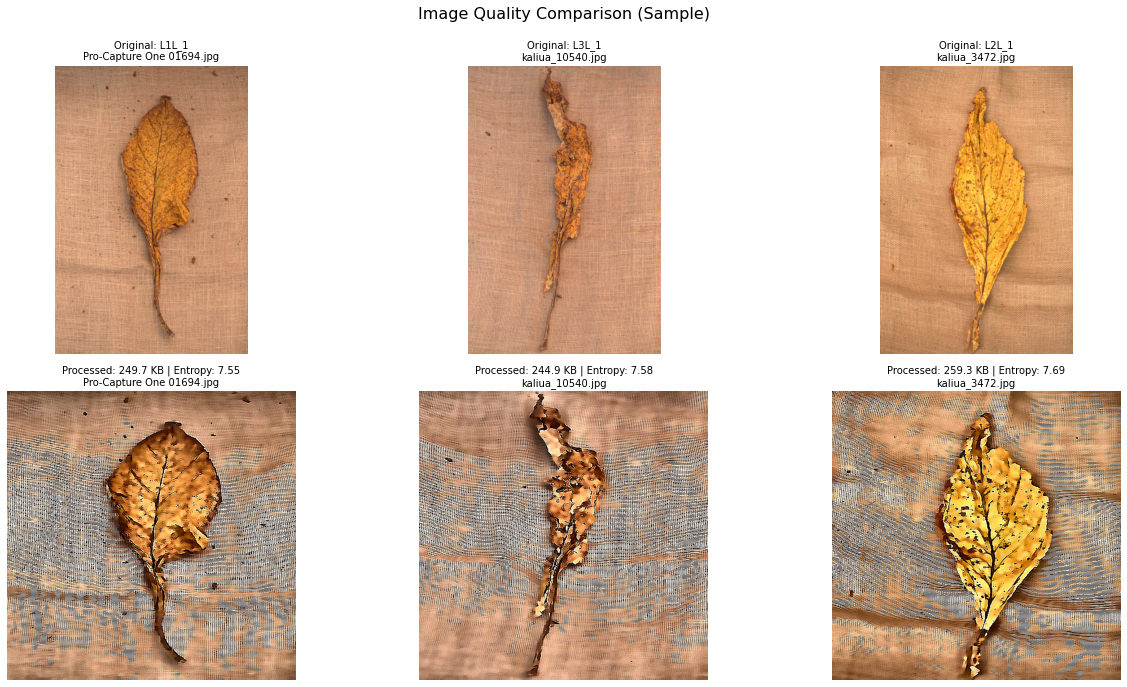

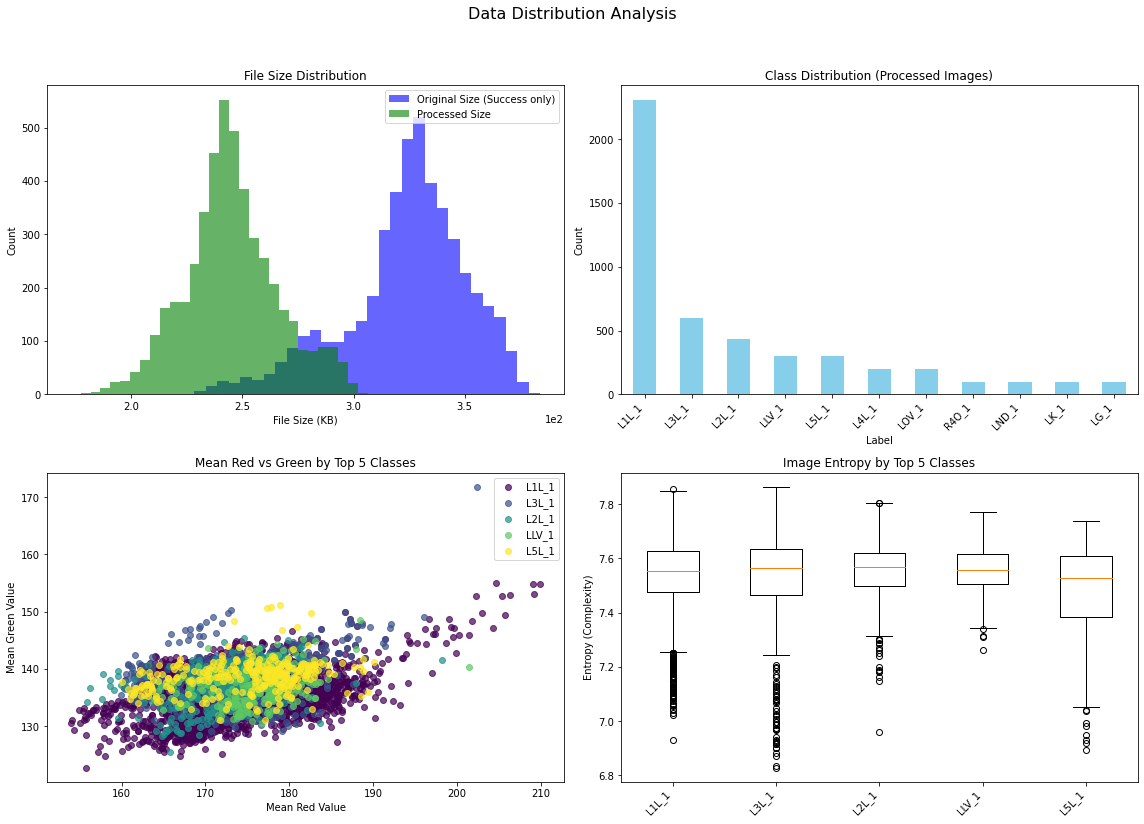

In [8]:
enhanced_process_images()

In [9]:
feature_extractor = EnhancedFeatureExtractor(
    use_ensemble=False,
    pca_components=128,
    target_size=(224, 224)
)

In [10]:
metadata = pd.read_csv(PATHS['metadata'])
valid_image_paths = metadata['processed_path'].dropna().tolist()

In [11]:
feature_extractor.process_and_save_features(
    valid_image_paths,
    batch_size=16,
    fit_processors_on_first_batch=True)  # Crucial for PCA/scaler

Processing Batch 1/297:   0%|          | 0/4739 [00:00<?, ?it/s]

Processing Batch 2/297:   0%|          | 16/4739 [00:06<34:08,  2.31it/s]

Processing Batch 3/297:   1%|          | 32/4739 [00:10<24:34,  3.19it/s]

Processing Batch 4/297:   1%|          | 48/4739 [00:15<23:19,  3.35it/s]

Processing Batch 5/297:   1%|▏         | 64/4739 [00:19<22:44,  3.43it/s]

Processing Batch 6/297:   2%|▏         | 80/4739 [00:23<20:49,  3.73it/s]

Processing Batch 7/297:   2%|▏         | 96/4739 [00:27<20:05,  3.85it/s]

Processing Batch 8/297:   2%|▏         | 112/4739 [00:31<19:43,  3.91it/s]

Processing Batch 9/297:   3%|▎         | 128/4739 [00:35<19:29,  3.94it/s]

Processing Batch 10/297:   3%|▎         | 144/4739 [00:38<18:34,  4.12it/s]

Processing Batch 11/297:   3%|▎         | 160/4739 [00:42<18:01,  4.23it/s]

Processing Batch 12/297:   4%|▎         | 176/4739 [00:46<18:15,  4.17it/s]

Processing Batch 13/297:   4%|▍         | 192/4739 [00:50<18:18,  4.14it/s]

Processing Batch 14/297:   4%|▍         | 208/4739 [00:53<17:42,  4.26it/s]

Processing Batch 15/297:   5%|▍         | 224/4739 [00:56<17:13,  4.37it/s]

Processing Batch 16/297:   5%|▌         | 240/4739 [01:00<17:20,  4.32it/s]

Processing Batch 17/297:   5%|▌         | 256/4739 [01:04<17:37,  4.24it/s]

Processing Batch 18/297:   6%|▌         | 272/4739 [01:08<17:29,  4.26it/s]

Processing Batch 19/297:   6%|▌         | 288/4739 [01:11<17:01,  4.36it/s]

Processing Batch 20/297:   6%|▋         | 304/4739 [01:15<17:01,  4.34it/s]

Processing Batch 21/297:   7%|▋         | 320/4739 [01:19<17:13,  4.28it/s]

Processing Batch 22/297:   7%|▋         | 336/4739 [01:23<17:17,  4.24it/s]

Processing Batch 23/297:   7%|▋         | 352/4739 [01:26<16:44,  4.37it/s]

Processing Batch 24/297:   8%|▊         | 368/4739 [01:30<16:31,  4.41it/s]

Processing Batch 25/297:   8%|▊         | 384/4739 [01:34<17:07,  4.24it/s]

Processing Batch 26/297:   8%|▊         | 400/4739 [01:38<17:18,  4.18it/s]

Processing Batch 27/297:   9%|▉         | 416/4739 [01:41<16:54,  4.26it/s]

Processing Batch 28/297:   9%|▉         | 432/4739 [01:45<16:41,  4.30it/s]

Processing Batch 29/297:   9%|▉         | 448/4739 [01:49<16:56,  4.22it/s]

Processing Batch 30/297:  10%|▉         | 464/4739 [01:53<17:00,  4.19it/s]

Processing Batch 31/297:  10%|█         | 480/4739 [01:57<17:36,  4.03it/s]

Processing Batch 32/297:  10%|█         | 496/4739 [02:01<16:49,  4.20it/s]

Processing Batch 33/297:  11%|█         | 512/4739 [02:05<16:51,  4.18it/s]

Processing Batch 34/297:  11%|█         | 528/4739 [02:08<16:57,  4.14it/s]

Processing Batch 35/297:  11%|█▏        | 544/4739 [02:12<16:51,  4.15it/s]

Processing Batch 36/297:  12%|█▏        | 560/4739 [02:16<16:22,  4.25it/s]

Processing Batch 37/297:  12%|█▏        | 576/4739 [02:20<16:59,  4.08it/s]

Processing Batch 38/297:  12%|█▏        | 592/4739 [02:24<17:20,  3.99it/s]

Processing Batch 39/297:  13%|█▎        | 608/4739 [02:28<17:03,  4.03it/s]

Processing Batch 40/297:  13%|█▎        | 624/4739 [02:32<17:06,  4.01it/s]

Processing Batch 41/297:  14%|█▎        | 640/4739 [02:37<17:20,  3.94it/s]

Processing Batch 42/297:  14%|█▍        | 656/4739 [02:41<17:43,  3.84it/s]

Processing Batch 43/297:  14%|█▍        | 672/4739 [02:45<17:30,  3.87it/s]

Processing Batch 44/297:  15%|█▍        | 688/4739 [02:48<16:35,  4.07it/s]

Processing Batch 45/297:  15%|█▍        | 704/4739 [02:52<16:23,  4.10it/s]

Processing Batch 46/297:  15%|█▌        | 720/4739 [02:56<16:21,  4.10it/s]

Processing Batch 47/297:  16%|█▌        | 736/4739 [03:00<16:13,  4.11it/s]

Processing Batch 48/297:  16%|█▌        | 752/4739 [03:03<15:36,  4.26it/s]

Processing Batch 49/297:  16%|█▌        | 768/4739 [03:08<16:17,  4.06it/s]

Processing Batch 50/297:  17%|█▋        | 784/4739 [03:12<16:10,  4.08it/s]

Processing Batch 51/297:  17%|█▋        | 800/4739 [03:15<15:41,  4.18it/s]

Processing Batch 52/297:  17%|█▋        | 816/4739 [03:19<15:08,  4.32it/s]

Processing Batch 53/297:  18%|█▊        | 832/4739 [03:22<14:59,  4.34it/s]

Processing Batch 54/297:  18%|█▊        | 848/4739 [03:26<15:12,  4.26it/s]

Processing Batch 55/297:  18%|█▊        | 864/4739 [03:30<15:18,  4.22it/s]

Processing Batch 56/297:  19%|█▊        | 880/4739 [03:34<15:04,  4.27it/s]

Processing Batch 57/297:  19%|█▉        | 896/4739 [03:37<14:40,  4.37it/s]

Processing Batch 58/297:  19%|█▉        | 912/4739 [03:41<14:59,  4.26it/s]

Processing Batch 59/297:  20%|█▉        | 928/4739 [03:45<15:08,  4.20it/s]

Processing Batch 60/297:  20%|█▉        | 944/4739 [03:49<14:37,  4.33it/s]

Processing Batch 61/297:  20%|██        | 960/4739 [03:52<14:18,  4.40it/s]

Processing Batch 62/297:  21%|██        | 976/4739 [03:56<14:30,  4.32it/s]

Processing Batch 63/297:  21%|██        | 992/4739 [04:00<14:39,  4.26it/s]

Processing Batch 64/297:  21%|██▏       | 1008/4739 [04:04<14:35,  4.26it/s]

Processing Batch 65/297:  22%|██▏       | 1024/4739 [04:07<14:12,  4.36it/s]

Processing Batch 66/297:  22%|██▏       | 1040/4739 [04:11<14:18,  4.31it/s]

Processing Batch 67/297:  22%|██▏       | 1056/4739 [04:15<14:25,  4.25it/s]

Processing Batch 68/297:  23%|██▎       | 1072/4739 [04:19<14:26,  4.23it/s]

Processing Batch 69/297:  23%|██▎       | 1088/4739 [04:22<13:59,  4.35it/s]

Processing Batch 70/297:  23%|██▎       | 1104/4739 [04:26<13:48,  4.39it/s]

Processing Batch 71/297:  24%|██▎       | 1120/4739 [04:30<14:09,  4.26it/s]

Processing Batch 72/297:  24%|██▍       | 1136/4739 [04:34<14:45,  4.07it/s]

Processing Batch 73/297:  24%|██▍       | 1152/4739 [04:38<14:15,  4.20it/s]

Processing Batch 74/297:  25%|██▍       | 1168/4739 [04:41<14:02,  4.24it/s]

Processing Batch 75/297:  25%|██▍       | 1184/4739 [04:46<14:38,  4.05it/s]

Processing Batch 76/297:  25%|██▌       | 1200/4739 [04:49<14:31,  4.06it/s]

Processing Batch 77/297:  26%|██▌       | 1216/4739 [04:53<13:54,  4.22it/s]

Processing Batch 78/297:  26%|██▌       | 1232/4739 [04:56<13:26,  4.35it/s]

Processing Batch 79/297:  26%|██▋       | 1248/4739 [05:00<13:28,  4.32it/s]

Processing Batch 80/297:  27%|██▋       | 1264/4739 [05:04<13:35,  4.26it/s]

Processing Batch 81/297:  27%|██▋       | 1280/4739 [05:08<13:32,  4.26it/s]

Processing Batch 82/297:  27%|██▋       | 1296/4739 [05:11<13:09,  4.36it/s]

Processing Batch 83/297:  28%|██▊       | 1312/4739 [05:15<13:08,  4.35it/s]

Processing Batch 84/297:  28%|██▊       | 1328/4739 [05:19<13:18,  4.27it/s]

Processing Batch 85/297:  28%|██▊       | 1344/4739 [05:23<13:20,  4.24it/s]

Processing Batch 86/297:  29%|██▊       | 1360/4739 [05:26<12:57,  4.35it/s]

Processing Batch 87/297:  29%|██▉       | 1376/4739 [05:30<12:41,  4.41it/s]

Processing Batch 88/297:  29%|██▉       | 1392/4739 [05:34<13:11,  4.23it/s]

Processing Batch 89/297:  30%|██▉       | 1408/4739 [05:38<13:16,  4.18it/s]

Processing Batch 90/297:  30%|███       | 1424/4739 [05:41<12:50,  4.30it/s]

Processing Batch 91/297:  30%|███       | 1440/4739 [05:45<12:31,  4.39it/s]

Processing Batch 92/297:  31%|███       | 1456/4739 [05:48<12:40,  4.31it/s]

Processing Batch 93/297:  31%|███       | 1472/4739 [05:52<12:48,  4.25it/s]

Processing Batch 94/297:  31%|███▏      | 1488/4739 [05:56<12:39,  4.28it/s]

Processing Batch 95/297:  32%|███▏      | 1504/4739 [05:59<12:16,  4.39it/s]

Processing Batch 96/297:  32%|███▏      | 1520/4739 [06:04<12:53,  4.16it/s]

Processing Batch 97/297:  32%|███▏      | 1536/4739 [06:08<12:49,  4.16it/s]

Processing Batch 98/297:  33%|███▎      | 1552/4739 [06:11<12:32,  4.23it/s]

Processing Batch 99/297:  33%|███▎      | 1568/4739 [06:15<12:09,  4.35it/s]

Processing Batch 100/297:  33%|███▎      | 1584/4739 [06:19<12:20,  4.26it/s]

Processing Batch 101/297:  34%|███▍      | 1600/4739 [06:23<12:26,  4.21it/s]

Processing Batch 102/297:  34%|███▍      | 1616/4739 [06:26<12:25,  4.19it/s]

Processing Batch 103/297:  34%|███▍      | 1632/4739 [06:30<12:08,  4.26it/s]

Processing Batch 104/297:  35%|███▍      | 1648/4739 [06:34<11:50,  4.35it/s]

Processing Batch 105/297:  35%|███▌      | 1664/4739 [06:37<12:02,  4.25it/s]

Processing Batch 106/297:  35%|███▌      | 1680/4739 [06:42<12:19,  4.13it/s]

Processing Batch 107/297:  36%|███▌      | 1696/4739 [06:45<12:00,  4.22it/s]

Processing Batch 108/297:  36%|███▌      | 1712/4739 [06:49<11:39,  4.32it/s]

Processing Batch 109/297:  36%|███▋      | 1728/4739 [06:53<11:44,  4.27it/s]

Processing Batch 110/297:  37%|███▋      | 1744/4739 [06:56<11:47,  4.23it/s]

Processing Batch 111/297:  37%|███▋      | 1760/4739 [07:00<11:52,  4.18it/s]

Processing Batch 112/297:  37%|███▋      | 1776/4739 [07:04<11:28,  4.30it/s]

Processing Batch 113/297:  38%|███▊      | 1792/4739 [07:08<11:25,  4.30it/s]

Processing Batch 114/297:  38%|███▊      | 1808/4739 [07:12<11:38,  4.20it/s]

Processing Batch 115/297:  38%|███▊      | 1824/4739 [07:16<11:43,  4.15it/s]

Processing Batch 116/297:  39%|███▉      | 1840/4739 [07:19<11:16,  4.29it/s]

Processing Batch 117/297:  39%|███▉      | 1856/4739 [07:23<11:06,  4.33it/s]

Processing Batch 118/297:  40%|███▉      | 1872/4739 [07:27<11:17,  4.23it/s]

Processing Batch 119/297:  40%|███▉      | 1888/4739 [07:31<11:49,  4.02it/s]

Processing Batch 120/297:  40%|████      | 1904/4739 [07:34<11:19,  4.17it/s]

Processing Batch 121/297:  41%|████      | 1920/4739 [07:38<11:00,  4.27it/s]

Processing Batch 122/297:  41%|████      | 1936/4739 [07:42<11:12,  4.17it/s]

Processing Batch 123/297:  41%|████      | 1952/4739 [07:46<11:16,  4.12it/s]

Processing Batch 124/297:  42%|████▏     | 1968/4739 [07:50<10:49,  4.26it/s]

Processing Batch 125/297:  42%|████▏     | 1984/4739 [07:53<10:29,  4.38it/s]

Processing Batch 126/297:  42%|████▏     | 2000/4739 [07:57<10:39,  4.28it/s]

Processing Batch 127/297:  43%|████▎     | 2016/4739 [08:01<10:43,  4.23it/s]

Processing Batch 128/297:  43%|████▎     | 2032/4739 [08:04<10:30,  4.29it/s]

Processing Batch 129/297:  43%|████▎     | 2048/4739 [08:08<10:11,  4.40it/s]

Processing Batch 130/297:  44%|████▎     | 2064/4739 [08:12<10:44,  4.15it/s]

Processing Batch 131/297:  44%|████▍     | 2080/4739 [08:16<10:40,  4.15it/s]

Processing Batch 132/297:  44%|████▍     | 2096/4739 [08:20<10:21,  4.25it/s]

Processing Batch 133/297:  45%|████▍     | 2112/4739 [08:23<10:02,  4.36it/s]

Processing Batch 134/297:  45%|████▍     | 2128/4739 [08:27<09:56,  4.38it/s]

Processing Batch 135/297:  45%|████▌     | 2144/4739 [08:31<10:03,  4.30it/s]

Processing Batch 136/297:  46%|████▌     | 2160/4739 [08:34<10:07,  4.25it/s]

Processing Batch 137/297:  46%|████▌     | 2176/4739 [08:38<09:47,  4.36it/s]

Processing Batch 138/297:  46%|████▋     | 2192/4739 [08:41<09:33,  4.44it/s]

Processing Batch 139/297:  47%|████▋     | 2208/4739 [08:45<09:52,  4.27it/s]

Processing Batch 140/297:  47%|████▋     | 2224/4739 [08:49<09:56,  4.21it/s]

Processing Batch 141/297:  47%|████▋     | 2240/4739 [08:53<09:51,  4.22it/s]

Processing Batch 142/297:  48%|████▊     | 2256/4739 [08:56<09:32,  4.34it/s]

Processing Batch 143/297:  48%|████▊     | 2272/4739 [09:00<09:33,  4.30it/s]

Processing Batch 144/297:  48%|████▊     | 2288/4739 [09:04<09:39,  4.23it/s]

Processing Batch 145/297:  49%|████▊     | 2304/4739 [09:09<09:58,  4.07it/s]

Processing Batch 146/297:  49%|████▉     | 2320/4739 [09:12<09:34,  4.21it/s]

Processing Batch 147/297:  49%|████▉     | 2336/4739 [09:16<09:33,  4.19it/s]

Processing Batch 148/297:  50%|████▉     | 2352/4739 [09:20<09:33,  4.16it/s]

Processing Batch 149/297:  50%|████▉     | 2368/4739 [09:24<09:30,  4.16it/s]

Processing Batch 150/297:  50%|█████     | 2384/4739 [09:27<09:09,  4.29it/s]

Processing Batch 151/297:  51%|█████     | 2400/4739 [09:31<09:03,  4.30it/s]

Processing Batch 152/297:  51%|█████     | 2416/4739 [09:35<09:17,  4.17it/s]

Processing Batch 153/297:  51%|█████▏    | 2432/4739 [09:39<09:26,  4.07it/s]

Processing Batch 154/297:  52%|█████▏    | 2448/4739 [09:42<09:02,  4.22it/s]

Processing Batch 155/297:  52%|█████▏    | 2464/4739 [09:46<08:57,  4.23it/s]

Processing Batch 156/297:  52%|█████▏    | 2480/4739 [09:50<09:02,  4.17it/s]

Processing Batch 157/297:  53%|█████▎    | 2496/4739 [09:54<09:02,  4.13it/s]

Processing Batch 158/297:  53%|█████▎    | 2512/4739 [09:58<08:40,  4.28it/s]

Processing Batch 159/297:  53%|█████▎    | 2528/4739 [10:01<08:36,  4.28it/s]

Processing Batch 160/297:  54%|█████▎    | 2544/4739 [10:06<08:54,  4.11it/s]

Processing Batch 161/297:  54%|█████▍    | 2560/4739 [10:10<08:52,  4.09it/s]

Processing Batch 162/297:  54%|█████▍    | 2576/4739 [10:13<08:48,  4.09it/s]

Processing Batch 163/297:  55%|█████▍    | 2592/4739 [10:17<08:27,  4.23it/s]

Processing Batch 164/297:  55%|█████▌    | 2608/4739 [10:21<08:27,  4.20it/s]

Processing Batch 165/297:  55%|█████▌    | 2624/4739 [10:25<08:30,  4.15it/s]

Processing Batch 166/297:  56%|█████▌    | 2640/4739 [10:29<08:23,  4.17it/s]

Processing Batch 167/297:  56%|█████▌    | 2656/4739 [10:32<08:05,  4.29it/s]

Processing Batch 168/297:  56%|█████▋    | 2672/4739 [10:36<08:01,  4.29it/s]

Processing Batch 169/297:  57%|█████▋    | 2688/4739 [10:40<08:04,  4.23it/s]

Processing Batch 170/297:  57%|█████▋    | 2704/4739 [10:44<08:02,  4.22it/s]

Processing Batch 171/297:  57%|█████▋    | 2720/4739 [10:47<07:45,  4.33it/s]

Processing Batch 172/297:  58%|█████▊    | 2736/4739 [10:51<07:47,  4.28it/s]

Processing Batch 173/297:  58%|█████▊    | 2752/4739 [10:55<07:51,  4.21it/s]

Processing Batch 174/297:  58%|█████▊    | 2768/4739 [10:59<07:52,  4.17it/s]

Processing Batch 175/297:  59%|█████▊    | 2784/4739 [11:02<07:35,  4.29it/s]

Processing Batch 176/297:  59%|█████▉    | 2800/4739 [11:06<07:22,  4.38it/s]

Processing Batch 177/297:  59%|█████▉    | 2816/4739 [11:10<07:28,  4.29it/s]

Processing Batch 178/297:  60%|█████▉    | 2832/4739 [11:14<07:33,  4.20it/s]

Processing Batch 179/297:  60%|██████    | 2848/4739 [11:17<07:22,  4.27it/s]

Processing Batch 180/297:  60%|██████    | 2864/4739 [11:21<07:08,  4.37it/s]

Processing Batch 181/297:  61%|██████    | 2880/4739 [11:24<07:11,  4.31it/s]

Processing Batch 182/297:  61%|██████    | 2896/4739 [11:29<07:20,  4.18it/s]

Processing Batch 183/297:  61%|██████▏   | 2912/4739 [11:33<07:39,  3.98it/s]

Processing Batch 184/297:  62%|██████▏   | 2928/4739 [11:36<07:17,  4.14it/s]

Processing Batch 185/297:  62%|██████▏   | 2944/4739 [11:40<07:10,  4.17it/s]

Processing Batch 186/297:  62%|██████▏   | 2960/4739 [11:44<07:11,  4.13it/s]

Processing Batch 187/297:  63%|██████▎   | 2976/4739 [11:48<07:02,  4.17it/s]

Processing Batch 188/297:  63%|██████▎   | 2992/4739 [11:51<06:46,  4.30it/s]

Processing Batch 189/297:  63%|██████▎   | 3008/4739 [11:55<06:41,  4.31it/s]

Processing Batch 190/297:  64%|██████▍   | 3024/4739 [12:00<07:03,  4.05it/s]

Processing Batch 191/297:  64%|██████▍   | 3040/4739 [12:03<06:56,  4.08it/s]

Processing Batch 192/297:  64%|██████▍   | 3056/4739 [12:07<06:37,  4.24it/s]

Processing Batch 193/297:  65%|██████▍   | 3072/4739 [12:11<06:31,  4.26it/s]

Processing Batch 194/297:  65%|██████▌   | 3088/4739 [12:15<06:34,  4.18it/s]

Processing Batch 195/297:  65%|██████▌   | 3104/4739 [12:19<06:34,  4.15it/s]

Processing Batch 196/297:  66%|██████▌   | 3120/4739 [12:22<06:18,  4.28it/s]

Processing Batch 197/297:  66%|██████▌   | 3136/4739 [12:25<06:06,  4.37it/s]

Processing Batch 198/297:  67%|██████▋   | 3152/4739 [12:29<06:10,  4.28it/s]

Processing Batch 199/297:  67%|██████▋   | 3168/4739 [12:33<06:11,  4.23it/s]

Processing Batch 200/297:  67%|██████▋   | 3184/4739 [12:37<06:05,  4.26it/s]

Processing Batch 201/297:  68%|██████▊   | 3200/4739 [12:40<05:52,  4.37it/s]

Processing Batch 202/297:  68%|██████▊   | 3216/4739 [12:44<05:52,  4.32it/s]

Processing Batch 203/297:  68%|██████▊   | 3232/4739 [12:48<05:55,  4.24it/s]

Processing Batch 204/297:  69%|██████▊   | 3248/4739 [12:52<06:07,  4.06it/s]

Processing Batch 205/297:  69%|██████▉   | 3264/4739 [12:56<05:49,  4.22it/s]

Processing Batch 206/297:  69%|██████▉   | 3280/4739 [13:00<05:43,  4.25it/s]

Processing Batch 207/297:  70%|██████▉   | 3296/4739 [13:04<05:44,  4.19it/s]

Processing Batch 208/297:  70%|██████▉   | 3312/4739 [13:07<05:42,  4.17it/s]

Processing Batch 209/297:  70%|███████   | 3328/4739 [13:11<05:28,  4.29it/s]

Processing Batch 210/297:  71%|███████   | 3344/4739 [13:15<05:22,  4.32it/s]

Processing Batch 211/297:  71%|███████   | 3360/4739 [13:19<05:24,  4.25it/s]

Processing Batch 212/297:  71%|███████   | 3376/4739 [13:22<05:23,  4.21it/s]

Processing Batch 213/297:  72%|███████▏  | 3392/4739 [13:26<05:11,  4.32it/s]

Processing Batch 214/297:  72%|███████▏  | 3408/4739 [13:29<05:01,  4.41it/s]

Processing Batch 215/297:  72%|███████▏  | 3424/4739 [13:33<05:11,  4.22it/s]

Processing Batch 216/297:  73%|███████▎  | 3440/4739 [13:38<05:13,  4.14it/s]

Processing Batch 217/297:  73%|███████▎  | 3456/4739 [13:41<05:01,  4.26it/s]

Processing Batch 218/297:  73%|███████▎  | 3472/4739 [13:44<04:49,  4.37it/s]

Processing Batch 219/297:  74%|███████▎  | 3488/4739 [13:48<04:49,  4.31it/s]

Processing Batch 220/297:  74%|███████▍  | 3504/4739 [13:52<04:50,  4.25it/s]

Processing Batch 221/297:  74%|███████▍  | 3520/4739 [13:56<04:50,  4.19it/s]

Processing Batch 222/297:  75%|███████▍  | 3536/4739 [14:00<04:38,  4.33it/s]

Processing Batch 223/297:  75%|███████▍  | 3552/4739 [14:03<04:32,  4.35it/s]

Processing Batch 224/297:  75%|███████▌  | 3568/4739 [14:07<04:37,  4.22it/s]

Processing Batch 225/297:  76%|███████▌  | 3584/4739 [14:11<04:37,  4.16it/s]

Processing Batch 226/297:  76%|███████▌  | 3600/4739 [14:15<04:25,  4.29it/s]

Processing Batch 227/297:  76%|███████▋  | 3616/4739 [14:18<04:17,  4.35it/s]

Processing Batch 228/297:  77%|███████▋  | 3632/4739 [14:22<04:20,  4.25it/s]

Processing Batch 229/297:  77%|███████▋  | 3648/4739 [14:26<04:22,  4.16it/s]

Processing Batch 230/297:  77%|███████▋  | 3664/4739 [14:30<04:10,  4.30it/s]

Processing Batch 231/297:  78%|███████▊  | 3680/4739 [14:33<04:01,  4.39it/s]

Processing Batch 232/297:  78%|███████▊  | 3696/4739 [14:37<04:01,  4.33it/s]

Processing Batch 233/297:  78%|███████▊  | 3712/4739 [14:41<04:03,  4.22it/s]

Processing Batch 234/297:  79%|███████▊  | 3728/4739 [14:45<04:01,  4.19it/s]

Processing Batch 235/297:  79%|███████▉  | 3744/4739 [14:48<03:50,  4.31it/s]

Processing Batch 236/297:  79%|███████▉  | 3760/4739 [14:52<03:47,  4.30it/s]

Processing Batch 237/297:  80%|███████▉  | 3776/4739 [14:56<03:47,  4.23it/s]

Processing Batch 238/297:  80%|████████  | 3792/4739 [15:00<03:46,  4.17it/s]

Processing Batch 239/297:  80%|████████  | 3808/4739 [15:03<03:36,  4.31it/s]

Processing Batch 240/297:  81%|████████  | 3824/4739 [15:07<03:32,  4.30it/s]

Processing Batch 241/297:  81%|████████  | 3840/4739 [15:11<03:33,  4.21it/s]

Processing Batch 242/297:  81%|████████▏ | 3856/4739 [15:15<03:32,  4.16it/s]

Processing Batch 243/297:  82%|████████▏ | 3872/4739 [15:18<03:21,  4.30it/s]

Processing Batch 244/297:  82%|████████▏ | 3888/4739 [15:22<03:14,  4.37it/s]

Processing Batch 245/297:  82%|████████▏ | 3904/4739 [15:26<03:13,  4.31it/s]

Processing Batch 246/297:  83%|████████▎ | 3920/4739 [15:30<03:12,  4.26it/s]

Processing Batch 247/297:  83%|████████▎ | 3936/4739 [15:34<03:11,  4.20it/s]

Processing Batch 248/297:  83%|████████▎ | 3952/4739 [15:37<03:02,  4.30it/s]

Processing Batch 249/297:  84%|████████▎ | 3968/4739 [15:41<03:02,  4.23it/s]

Processing Batch 250/297:  84%|████████▍ | 3984/4739 [15:45<02:59,  4.20it/s]

Processing Batch 251/297:  84%|████████▍ | 4000/4739 [15:49<02:56,  4.19it/s]

Processing Batch 252/297:  85%|████████▍ | 4016/4739 [15:52<02:47,  4.31it/s]

Processing Batch 253/297:  85%|████████▌ | 4032/4739 [15:56<02:43,  4.31it/s]

Processing Batch 254/297:  85%|████████▌ | 4048/4739 [16:00<02:43,  4.23it/s]

Processing Batch 255/297:  86%|████████▌ | 4064/4739 [16:04<02:47,  4.04it/s]

Processing Batch 256/297:  86%|████████▌ | 4080/4739 [16:08<02:36,  4.20it/s]

Processing Batch 257/297:  86%|████████▋ | 4096/4739 [16:11<02:32,  4.22it/s]

Processing Batch 258/297:  87%|████████▋ | 4112/4739 [16:15<02:31,  4.14it/s]

Processing Batch 259/297:  87%|████████▋ | 4128/4739 [16:20<02:31,  4.03it/s]

Processing Batch 260/297:  87%|████████▋ | 4144/4739 [16:23<02:22,  4.16it/s]

Processing Batch 261/297:  88%|████████▊ | 4160/4739 [16:27<02:17,  4.22it/s]

Processing Batch 262/297:  88%|████████▊ | 4176/4739 [16:31<02:18,  4.06it/s]

Processing Batch 263/297:  88%|████████▊ | 4192/4739 [16:35<02:15,  4.04it/s]

Processing Batch 264/297:  89%|████████▉ | 4208/4739 [16:39<02:06,  4.19it/s]

Processing Batch 265/297:  89%|████████▉ | 4224/4739 [16:42<02:02,  4.21it/s]

Processing Batch 266/297:  89%|████████▉ | 4240/4739 [16:46<02:00,  4.15it/s]

Processing Batch 267/297:  90%|████████▉ | 4256/4739 [16:50<01:57,  4.13it/s]

Processing Batch 268/297:  90%|█████████ | 4272/4739 [16:54<01:49,  4.27it/s]

Processing Batch 269/297:  90%|█████████ | 4288/4739 [16:57<01:43,  4.37it/s]

Processing Batch 270/297:  91%|█████████ | 4304/4739 [17:01<01:41,  4.27it/s]

Processing Batch 271/297:  91%|█████████ | 4320/4739 [17:05<01:39,  4.20it/s]

Processing Batch 272/297:  91%|█████████▏| 4336/4739 [17:09<01:34,  4.28it/s]

Processing Batch 273/297:  92%|█████████▏| 4352/4739 [17:12<01:28,  4.36it/s]

Processing Batch 274/297:  92%|█████████▏| 4368/4739 [17:16<01:26,  4.31it/s]

Processing Batch 275/297:  93%|█████████▎| 4384/4739 [17:20<01:23,  4.24it/s]

Processing Batch 276/297:  93%|█████████▎| 4400/4739 [17:24<01:19,  4.24it/s]

Processing Batch 277/297:  93%|█████████▎| 4416/4739 [17:27<01:14,  4.35it/s]

Processing Batch 278/297:  94%|█████████▎| 4432/4739 [17:31<01:11,  4.32it/s]

Processing Batch 279/297:  94%|█████████▍| 4448/4739 [17:35<01:09,  4.18it/s]

Processing Batch 280/297:  94%|█████████▍| 4464/4739 [17:39<01:06,  4.16it/s]

Processing Batch 281/297:  95%|█████████▍| 4480/4739 [17:42<01:00,  4.28it/s]

Processing Batch 282/297:  95%|█████████▍| 4496/4739 [17:46<00:55,  4.36it/s]

Processing Batch 283/297:  95%|█████████▌| 4512/4739 [17:50<00:55,  4.12it/s]

Processing Batch 284/297:  96%|█████████▌| 4528/4739 [17:54<00:51,  4.12it/s]

Processing Batch 285/297:  96%|█████████▌| 4544/4739 [17:58<00:45,  4.27it/s]

Processing Batch 286/297:  96%|█████████▌| 4560/4739 [18:01<00:40,  4.38it/s]

Processing Batch 287/297:  97%|█████████▋| 4576/4739 [18:05<00:37,  4.31it/s]

Processing Batch 288/297:  97%|█████████▋| 4592/4739 [18:09<00:34,  4.24it/s]

Processing Batch 289/297:  97%|█████████▋| 4608/4739 [18:13<00:30,  4.27it/s]

Processing Batch 290/297:  98%|█████████▊| 4624/4739 [18:16<00:26,  4.38it/s]

Processing Batch 291/297:  98%|█████████▊| 4640/4739 [18:20<00:22,  4.33it/s]

Processing Batch 292/297:  98%|█████████▊| 4656/4739 [18:24<00:19,  4.27it/s]

Processing Batch 293/297:  99%|█████████▊| 4672/4739 [18:27<00:15,  4.25it/s]

Processing Batch 294/297:  99%|█████████▉| 4688/4739 [18:31<00:11,  4.37it/s]

Processing Batch 295/297:  99%|█████████▉| 4704/4739 [18:35<00:07,  4.39it/s]

Processing Batch 296/297: 100%|█████████▉| 4720/4739 [18:38<00:04,  4.29it/s]

Processing Batch 297/297: 100%|█████████▉| 4736/4739 [18:42<00:00,  4.22it/s]

Processing Batch 297/297: 100%|██████████| 4739/4739 [18:43<00:00,  4.22it/s]


WindowsPath('tobacco_grading/data/processed/full_features.parquet')

FloatProgress(value=0.0, bar_style='info', description='Initializing...', max=8.0)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


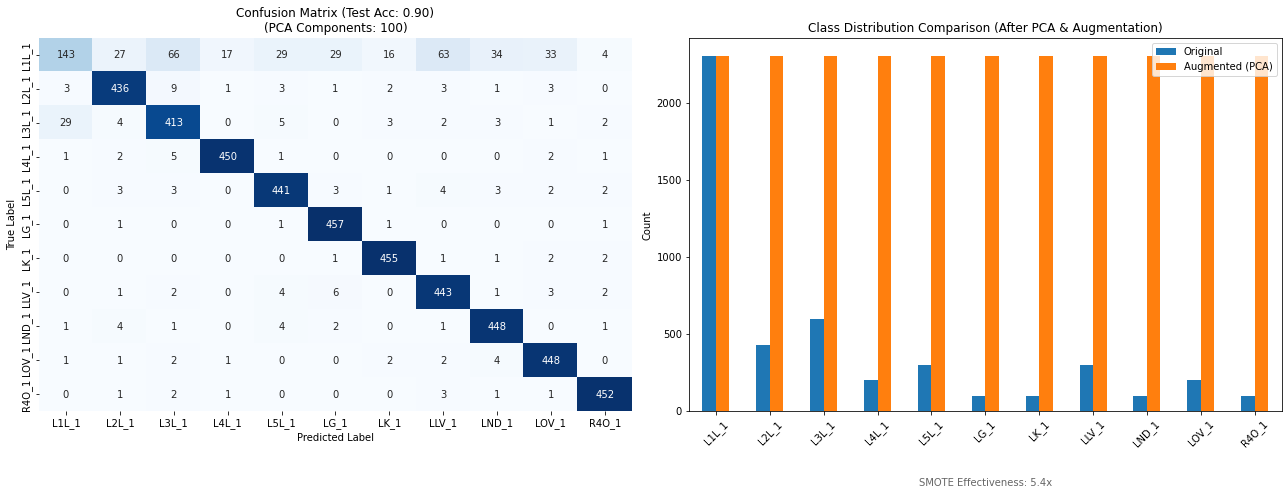

(KNeighborsClassifier(metric='manhattan', weights='distance'),
     Class  Precision    Recall  F1-Score  Support Reliable
 0   L1L_1   0.803371  0.310195  0.447574      461        ✓
 1   L2L_1   0.908333  0.943723  0.925690      462        ✓
 2   L3L_1   0.821074  0.893939  0.855959      462        ✓
 3   L4L_1   0.957447  0.974026  0.965665      462        ✓
 4   L5L_1   0.903689  0.954545  0.928421      462        ✓
 5    LG_1   0.915832  0.991323  0.952083      461        ✓
 6    LK_1   0.947917  0.984848  0.966030      462        ✓
 7   LLV_1   0.848659  0.958874  0.900407      462        ✓
 8   LND_1   0.903226  0.969697  0.935282      462        ✓
 9   LOV_1   0.905051  0.971800  0.937238      461        ✓
 10  R4O_1   0.967880  0.980477  0.974138      461        ✓,
 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
              estimator=KNeighborsClassifier(), n_jobs=-1,
              param_grid={'metric': ['euclidean', 'manhattan', 'cosine'],
    

In [10]:
enhanced_train_and_evaluate_knn_with_pca(n_components_pca=100)  # ✅ Works now!